# Target encoding

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from feature_engine.encoding import RareLabelEncoder
from feature_engine.selection import SelectByTargetMeanPerformance

In [2]:
# load titanic dataset

variables = ['pclass', 'survived', 'sex', 'age',
             'sibsp', 'parch', 'fare', 'cabin', 'embarked']

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl',
                   usecols=variables,
                   na_values='?',
                   dtype={'fare': float, 'age': float},
                   )

data.dropna(subset=['embarked', 'fare'], inplace=True)
data['age'] = data['age'].fillna(data['age'].mean())


def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return 'N'


data['cabin'] = data['cabin'].apply(get_first_cabin).str[0]
encoder = RareLabelEncoder(variables='cabin', n_categories=2)
data = encoder.fit_transform(data)

data.head()

pclass  survived     sex      age  sibsp  parch      fare cabin embarked
0       1         1  female  29.0000      0      0  211.3375  Rare        S
1       1         1    male   0.9167      1      2  151.5500     C        S
2       1         0  female   2.0000      1      2  151.5500     C        S
3       1         0    male  30.0000      1      2  151.5500     C        S
4       1         0  female  25.0000      1      2  151.5500     C        S

In [3]:
# separate data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),
    data['survived'],
    test_size=0.3,
    random_state=0,
)

X_train.shape, X_test.shape

((914, 8), (392, 8))

In [4]:
sel = SelectByTargetMeanPerformance(
    bins=5,
    strategy='equal_frequency',
    scoring='roc_auc',
    cv=2,
    threshold=None,
    regression=False,
)

sel.fit(X_train, y_train)

SelectByTargetMeanPerformance(cv=2, strategy='equal_frequency')

In [5]:
# the features that will be removed

sel.features_to_drop_

['age', 'sibsp', 'parch', 'embarked']

In [6]:
# the performance estimated for each feature

sel.feature_performance_

{'pclass': 0.6551893232380663,
 'sex': 0.7491001943282519,
 'age': 0.5382483653274581,
 'sibsp': 0.5183970828336429,
 'parch': 0.5068146044866522,
 'fare': 0.6753892717910286,
 'cabin': 0.6385761238147736,
 'embarked': 0.5630695122556864}

Text(0.5, 1.0, 'Feature performance based on target encoding')

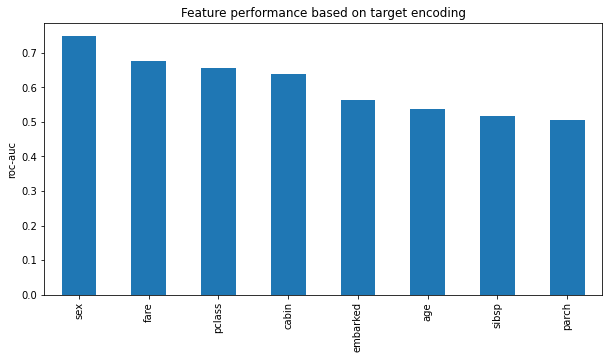

In [7]:
pd.Series(sel.feature_performance_).sort_values(
    ascending=False).plot.bar(figsize=(10, 5))

plt.ylabel('roc-auc')
plt.title('Feature performance based on target encoding')

In [8]:
# drop features

X_train_t = sel.transform(X_train)
X_test_t = sel.transform(X_test)

X_train_t.shape, X_test_t.shape

((914, 4), (392, 4))

In [9]:
X_train.head()

pclass   sex        age  sibsp  parch     fare cabin embarked
842        3  male  29.813199      1      0  19.9667     N        S
868        3  male  43.000000      0      0   6.4500     N        S
429        2  male  44.000000      0      0  13.0000     N        S
480        2  male  25.000000      1      2  41.5792     N        C
1308       3  male  29.000000      0      0   7.8750     N        S